In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [16]:
train_dir = '/home/student/Documents/220962366/data/cats_and_dogs_filtered/train'
test_dir = '/home/student/Documents/220962366/data/cats_and_dogs_filtered/validation'

mytf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.ImageFolder(train_dir, transform=mytf)
test_data = datasets.ImageFolder(test_dir, transform=mytf)

batchSize = 4

train_loader = DataLoader(train_data, batchSize, shuffle=True)
test_loader = DataLoader(test_data, batchSize, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        feature_size = self.get_dims()
        # print("Feature size = ", feature_size)

        self.classification = nn.Sequential(
            nn.Linear(feature_size, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        fs = self.net(x)
        return self.classification(fs)
    
    def get_dims(self):
        dummy = torch.randn(1, 3, 224, 224)
        y = self.net(dummy)
        return y.numel()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

model = CNN().to(device)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model2 = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)
model2.classifier[-1] = nn.Linear(4096, 2, bias=True)
for p in model2.parameters():
    p.requires_grad = False

for p in model2.classifier[-1].parameters():
    p.requires_grad = True

print(model2)
print("Number of trainable parameters in Model 2 = ", sum(p.numel() for p in model2.parameters() if p.requires_grad))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
epochs = 20

loss_list = []
val_loss_list = []
accuracy_list = []
val_acc_list = []

def count_correct(out, lab):
    return sum(out.argmax(1) == lab).item()

for ep in range(epochs):
    rloss = 0
    corr = 0
    model.train()
    for inp, lab in train_loader:
        inp, lab = inp.to(device), lab.to(device)

        out = model(inp)
        loss = criteria(out, lab)
        
        # L2 regularization
        l2_reg = torch.tensor(0.)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        
        l2_lambda = 0.001
        loss += l2_lambda * l2_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rloss += loss
        corr += count_correct(out, lab)
    
    tloss = rloss / len(train_loader)
    tacc = 100 * (corr / (len(train_loader) * batchSize))
    loss_list.append(tloss.item())
    accuracy_list.append(tacc)

    rloss = 0
    corr = 0
    model.eval()

    for inp, lab in test_loader:
        inp, lab = inp.to(device), lab.to(device)
        
        with torch.no_grad():
            out = model(inp)
        
        rloss += criteria(out, lab)
        corr += count_correct(out, lab)
    
    vloss = rloss / len(test_loader)
    vacc = 100 * (corr / (len(test_loader) * batchSize))

    val_loss_list.append(vloss)
    val_acc_list.append(vacc)

    print(f"Ep {ep+1}/{epochs}: TrainLoss = {tloss:.4f}, ValLoss = {vloss:.4f}, TrainAcc = {tacc:.2f}%, ValAcc = {vacc:.2f}%")
    

Ep 1/20: TrainLoss = 0.6924, ValLoss = 0.6859, TrainAcc = 51.00%, ValAcc = 57.50%
Ep 2/20: TrainLoss = 0.6899, ValLoss = 0.7009, TrainAcc = 54.35%, ValAcc = 50.00%
Ep 3/20: TrainLoss = 0.6833, ValLoss = 0.6651, TrainAcc = 56.80%, ValAcc = 60.60%
Ep 4/20: TrainLoss = 0.6684, ValLoss = 0.6598, TrainAcc = 61.45%, ValAcc = 61.20%
Ep 5/20: TrainLoss = 0.6442, ValLoss = 0.6878, TrainAcc = 63.30%, ValAcc = 57.60%
Ep 6/20: TrainLoss = 0.6182, ValLoss = 0.6409, TrainAcc = 66.20%, ValAcc = 64.10%


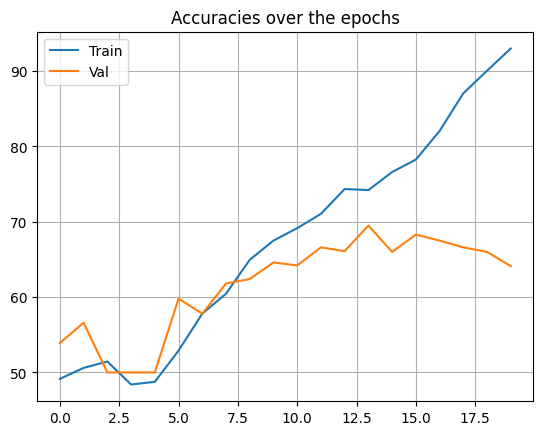

In [ ]:
plt.title("Loss vs Epoch")
plt.plot(loss_list, label = "Train")
plt.plot(val_loss_list, label = "Val")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

plt.title("Accuracies over the epochs")
plt.plot(accuracy_list, label = "Train")
plt.plot(val_acc_list, label = "Val")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.show()

In [ ]:
checkpoint = {
    "epochs":epochs,
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict()
}
ch_path = f'./checkpoints/chkpt_ep{epochs}.pth'
torch.save(checkpoint, ch_path)